# ESD 40.317 Financial Systems Design 
## Part 2 Assignment 1
### Due: 12 July before midnight 

Do not change any of the function definitions or variable names that are given in the cells for you to provide the solution. These function and variable names are used to autograde your solution and changing them might cause the autograder to fail and hence award 0 marks.

### Question 1: Risk neutral measure and Arrow securities

Consider a financial asset current priced at \\$100. There are only 5 possible states for this asset price in the next period: 
1. \\$50
2. \\$75 
3. \\$100
4. \\$125 
5. \\$x 

There are Arrow securities trading with a payout corresponding to each of these states (recall that an Arrow security pays out \\$1 in a specific state and $0 for all other states). 

| State | Price of asset in next period | Price of Arrow security paying $1 in current period |
|:-----:|:-----------------------------:|:---------------------------------------------------:|
|   1   |             \\$50.00          |                       \\$0.05                       |
|   2   |             \\$75.00          |                       \\$0.15                       |
|   3   |             \\$100.00         |                       \\$0.45                       |
|   4   |             \\$125.00         |                       \\$0.20                       |
|   5   |             \\$x              |                       \\$0.10                       |


Assume that you can buy or short both the asset and the Arrow securities in any **integer** amount for the questions below.

Run the cell below which imports the packages required for a) to d).

In [1]:
import numpy as np
import math

a) What is the implied interest rate per period based on the prices of the Arrow securities if there is no arbitrage in the system (assume it is the same for both borrowing and deposits)? 

(10 marks)

Run the cell below where the Arrow securities' prices have been assigned to a numpy array. In the following cell, calculate the value of the implied interest rate and assign it to the variable **rate**. The value must be at least accurate to 4 significant figures.

In [2]:
arrows = np.array([0.05, 0.15, 0.45, 0.2, 0.1])

In [3]:
rate = (1/np.sum(arrows))-1
rate

0.05263157894736836

In [4]:
assert isinstance(rate, float)
assert rate > 0

b) What should x be to prevent arbitrage in the system? 

(10 marks)

Run the cell below where the asset price in the first 4 states have been assigned to a numpy array. In the following cell, assign the correct value to the variable **x**.

In [5]:
partial_states = np.array([50, 75, 100, 125])

In [6]:
price = np.array([0.05, 0.15, 0.45, 0.2])
x = (100-np.dot(price, partial_states))/0.1
# x 

In [7]:
assert x > 0

c)	What if x were \\$150? How do you construct an arbitrage opportunity? 

(15 marks)

In the coding cell below, set the amounts you will buy or sell the asset and the Arrow securities to create the arbitrage opportunity. For example, if you would like to:
1. Buy 1 unit of the asset
2. Short sell 10 units of Arrow security for state 1
3. Short sell 20 units of Arrow security for state 2
4. Short sell 30 units of Arrow security for state 3
5. Buy 40 units of Arrow security for state 4
6. Buy 50 units of Arrow security for state 5

Then you should set the weights to:  
asset_weight = 1  
arrow_weights = [-10, -20, -30, 40, 50]

Note that the possible weight combinations to create an arbitrage opportunity is infinite i.e. the answer is not unique. You just need to show one combination that works.

In [8]:
# CHANGE WEIGHTS BELOW
asset_weight = -1
arrow_weights = np.array([50, 75, 100, 125, 150])

In [9]:
assert isinstance(asset_weight, int)
assert all([float(i).is_integer() for i in arrow_weights])

d) We now add a European put option on the financial asset with a strike of \\$85 to this 2 period finite state world. How much should this option cost based on the arbitrage free price for x that you have found from b)? 

(15 marks)

Run the cell below where all 5 states for the assert price have been assigned to a numpy array and the put strike to a variable. In the following cell, assign the correct value to the variable **px**. The value must be at least accurate to 4 significant figures.

You can use the [numpy.maximum](https://numpy.org/doc/stable/reference/generated/numpy.maximum.html) function in your solution.

In [10]:
states = np.array([50, 75, 100, 125, x])
strike = 85.

In [11]:
prob = arrows/np.sum(arrows)
payout = strike - states

# obtain the payout at the next time period
# payout is >= 0 depending on the value of the derivative in the respective states
get_payout = lambda p: max(p, 0)
# get the new payout
new_payout = np.array([get_payout(i) for i in payout])
# get the expected payout by multiplying the payout with their respective probabilities
expected_payout = sum(prob*new_payout)
# expected_payout = 3.4210526315789473
px = expected_payout*math.exp(-rate) # ADD CODE HERE
# px = 3.245653484266759
# can also just take new_payout * arrows cos the pv is already inside the arrows state

In [12]:
assert isinstance(px, float)
assert px > 0

### Question 2: Solving for Implied Volatility

The optimizer in scipy also has an implementation for [Halley’s method](https://en.wikipedia.org/wiki/Halley%27s_method) which has a higher rate of convergence then Newton-Raphson. You will implement this method yourself in this assignment. The method requires both the first (vega) and second (vomma/volga) derivative with respect to volatility given below:

Vega: $\frac{\partial V}{\partial \sigma}=SN'(d_1)\sqrt{T}$

Vomma/Volga: $\frac{\partial^2 V}{\partial \sigma^2}=SN'(\frac{d_1d_2}{\sigma})\sqrt{T}$

where $V$ is the price function of the derivative, $S$ is stock price, $N'(x)=\frac{1}{\sqrt{2\pi}} e^{-x^2/2}$ which is the pdf of the standard Normal distribution, $T$ is time to maturity and $d_1=\frac{1}{\sigma\sqrt{T}}\left[\ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)T\right]$, $d_2=d_1 - \sigma\sqrt{T}$ are the same as in the standard Black Scholes formulation.

For the iterations, use the alternative formulation given below:
$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}\left[1-\frac{f(x_n)f''(x_n)}{2f'(x_n)^2}\right]
$$

First, import the packages in the first cell below. Then complete the code in the following cell for the two functions defined below:  

**px_vega_vomma** is a function that takes in all the parameters to price an European call or put option and a boolean argument otype which is set to True (default) for a call and False for a put. You are to add the missing code to calculate vega and vomma in the function.  

**halley** is a function that takes in 4 arguments:
1. **f** is the mathematical function (provided below) which we need to solve for the roots and is also used to calculate the derivatives vega and vomma 
2. **guess** is the initial guess for the solution
3. **args** is the additional arguments required for the function f
4. **tol**=10e-6 by default defines the required precision for the solution  

Add the missing code to implement the function as an generator using the **yield** statement. The function will first check the value of f based on the provided guess. If the guess is within the tolerance for the solution then the function ends with no further action. If the guess is not within the tolerance, then further iterations are required. The function should **yield** the iterated guesses that approach the solution. 

(30 marks)

If you are new to the use of **yield** statements, read [this](https://www.geeksforgeeks.org/use-yield-keyword-instead-return-keyword-python/) to learn more.

In [13]:
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def px_vega_vomma(sigma, S, K, T, r, otype=True):
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = (math.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    
    # if optype==True then compute call option value else compute put option value
    if otype:
        px = S*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2)
    else:
        px = K*math.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1) 
    
    vega = S*norm.pdf(d1)*T**0.5 # ADD CODE HERE
    vomma = S*norm.pdf(d1*d2/sigma)*T**0.5 # ADD CODE HERE
    
    return px, vega, vomma

def halley(f, guess, args, tol=10**-6):
    f_guess, vega, vomma = f(guess, *args)                  # evaluate f based on guess and calculate vega, vomma
    if(abs(f_guess) > tol):                                 # check if f(guess) is within tolerance
        yield guess
        next_guess = guess - f_guess/vega*(1 - f_guess*vomma/2/vega**2)
        yield from halley(f, next_guess, args, tol)
        # ADD CODE HERE
        # ~3 lines of code
        # solution below:
#         next_guess = guess - f_guess/vega*(1 - f_guess*vomma/2/vega**2)
#         yield next_guess
#         yield from halley(f, next_guess, args, tol)

In [14]:
def f(x, S, r, K, T, listed_px, otype=True):
    px, vega, vomma = px_vega_vomma(x, S, K, T, r, otype)
    return (px - listed_px), vega, vomma

S = 100.; K = 100.; T = 0.5; r = 0.01; listed_px = 8.; otype = True

guess = 1
x_generator = halley(f, guess, args=(S, r, K, T, listed_px, otype))
count = 0
for x in x_generator:
    count += 1
    print('Iteration:', count, '-> sigma =', x)

assert x > 0.27578
assert x < 0.27579

Iteration: 1 -> sigma = 0.5479007706526913
Iteration: 2 -> sigma = 0.31200176896955806
Iteration: 3 -> sigma = 0.27642414887401934
Iteration: 4 -> sigma = 0.2757856982337853
Iteration: 5 -> sigma = 0.2757854994003765


The cell below tries using **guess = 5** as the initial value for the algorithm. Run it and see what happens.

Why does the solution fail to converge? Run the cell further below to plot the graph of the function **f** and provide an analysis of why the convergence failed in the last markdown cell below. You can use this [visualizer](https://observablehq.com/@herbps10/halleys-method) to understand what Halley's method does geometrically. It is similar to the Newton-Raphson method except, instead of using a straight line tangent to find the next iteration, it uses the second derivative to add convexity (curvature) to the tangent.   

(20 marks)

In [15]:
guess = 5
x_generator = halley(f, guess, args=(S, r, K, T, listed_px, otype))
count = 0
for x in x_generator:
    count += 1
    print('Iteration:', count, '-> sigma =', x)

Iteration: 1 -> sigma = 392.6091960159699
Iteration: 2 -> sigma = nan


C:\Users\eugen\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\eugen\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\eugen\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\eugen\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\eugen\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
C:\Users\eugen\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\eugen\Anaconda3\lib\site-packages\scipy\stats\_distn_infras

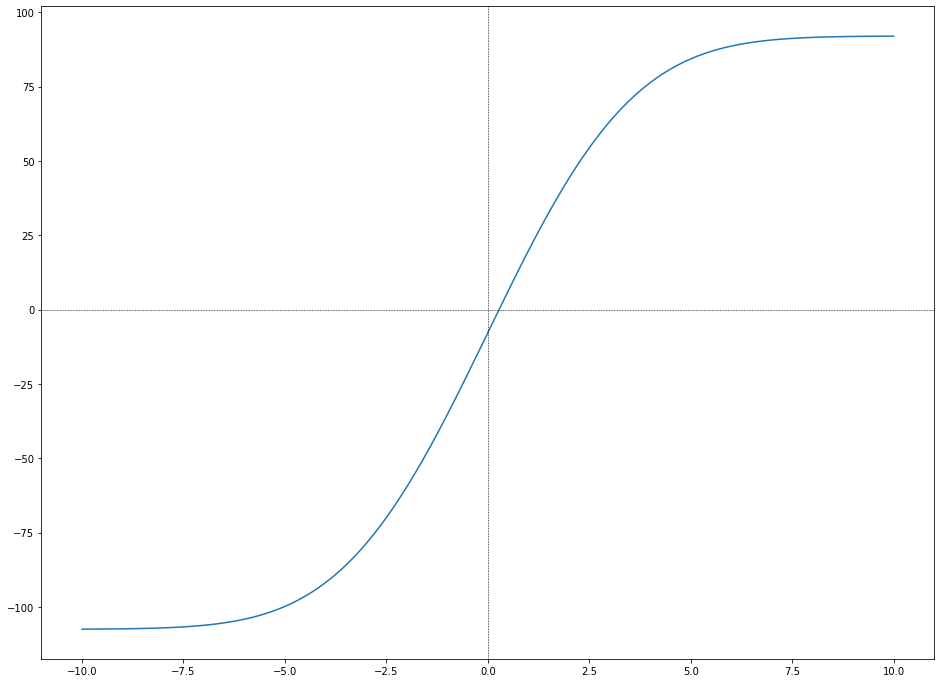

In [32]:
S0 = 100.; K = 100.; T = 0.5; r = 0.01; listed_px = 8.; otype = True

x = np.linspace(-10, 10, 5000)
call_px, _, _ = px_vega_vomma(x, S0, K, T, r, True)
call = call_px - listed_px

plt.figure(1, figsize=(16, 12))
plt.plot(x, call)
plt.axhline(y=0, color='black', ls='--', lw=0.5)
plt.axvline(x=0, color='black', ls='--', lw=0.5)

YOUR ANSWER HERE

As seen from the graph above, f(x) starts to approach an asymptote around x=5. It also has a point of inflection around x=1
 
It may be that the derivative f'(x=5)$\approx$0 such that squaring this value results in an even smaller value. This results in an error in Halley's method as it does not obey the formulation based on Taylor's Theorem. As seen in the iterative formula used above, it may have resulted in a division of 0 resulting in the error. 

This divergence can be also observed in the formula:
$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}\left[1-\frac{f(x_n)f''(x_n)}{2f'(x_n)^2}\right]
$$

It can be observed from the shape of the graph that f(x=5)$\approx$80, f'(x=5)$\approx$0 and f''(x=5)<0 such that $\left[1-\frac{f(x_n)f''(x_n)}{2f'(x_n)^2}\right]\approx$ very large positive number and $x_{n+1}\approx$ very large negative number

Repeated iterations results in oscillations between larger and larger positive and negative values which are further and further away from the root causing the divergence 